In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import tensorflow as tf

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))   

In [2]:
# Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Self Attention Mechanism
class SelfAttention(layers.Layer):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        self.query_weights = layers.Dense(self.head_dim)
        self.key_weights = layers.Dense(self.head_dim)
        self.value_weights = layers.Dense(self.head_dim)
        self.fc_out = layers.Dense(embed_size)

    def call(self, values, keys, query, mask):
        Q = self.query_weights(query)
        K = self.key_weights(keys)
        V = self.value_weights(values)

        matmul_qk = tf.matmul(Q, K, transpose_b=True)
        d_k = tf.cast(tf.shape(K)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        out = tf.matmul(attention_weights, V)

        return out

In [3]:
# Convert all layers to 1D version
def conv_block_1d(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv1D(filters, kernelsize, kernel_initializer='he_normal', padding="same")(x)
    if batchnorm:
        conv = layers.BatchNormalization(axis=2)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv1D(filters, kernelsize, kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm:
        conv = layers.BatchNormalization(axis=2)(conv)
    conv = layers.Activation("relu")(conv)
    return conv



def SelfAttentionuNet_1D(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3

    inputs = layers.Input(input_shape) 

    dn_1 = conv_block_1d(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling1D(pool_size=2)(dn_1)
    
    dn_2 = conv_block_1d(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling1D(pool_size=2)(dn_2)
    
    dn_3 = conv_block_1d(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling1D(pool_size=2)(dn_3)
    
    dn_4 = conv_block_1d(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling1D(pool_size=2)(dn_4)
    
    dn_5 = conv_block_1d(pool_4, kernelsize, filters[4], dropout, batchnorm)
    
    x = PositionalEncoding(dn_4.shape[1], dn_4.shape[2])(dn_4)
    att_5 = SelfAttention(dn_4.shape[2], 1)(x, x, x, mask=None)
    up_5 = layers.UpSampling1D(size=2)(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=2)
    up_conv_5 = conv_block_1d(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    x = PositionalEncoding(dn_3.shape[1], dn_3.shape[2])(dn_3)
    att_4 = SelfAttention(dn_3.shape[2], 1)(x, x, x, mask=None)
    up_4 = layers.UpSampling1D(size=2)(dn_4)
    up_4 = layers.concatenate([up_4, att_4], axis=2)
    up_conv_4 = conv_block_1d(up_4, kernelsize, filters[3], dropout, batchnorm)
       
    x = PositionalEncoding(dn_2.shape[1], dn_2.shape[2])(dn_2)
    att_3 = SelfAttention(dn_2.shape[2], 1)(x, x, x, mask=None)
    up_3 = layers.UpSampling1D(size=2)(dn_3)
    up_3 = layers.concatenate([up_3, att_3], axis=2)
    up_conv_3 = conv_block_1d(up_3, kernelsize, filters[3], dropout, batchnorm)
    
    x = PositionalEncoding(dn_1.shape[1], dn_1.shape[2])(dn_1)
    att_2 = SelfAttention(dn_1.shape[2], 1)(x, x, x, mask=None)
    up_2 = layers.UpSampling1D(size=2)(dn_2)
    up_2 = layers.concatenate([up_2, att_2], axis=2)
    up_conv_2 = conv_block_1d(up_2, kernelsize, filters[3], dropout, batchnorm)
    
    conv_final = layers.Conv1D(1, kernel_size=1)(up_conv_2)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    


### Toy data

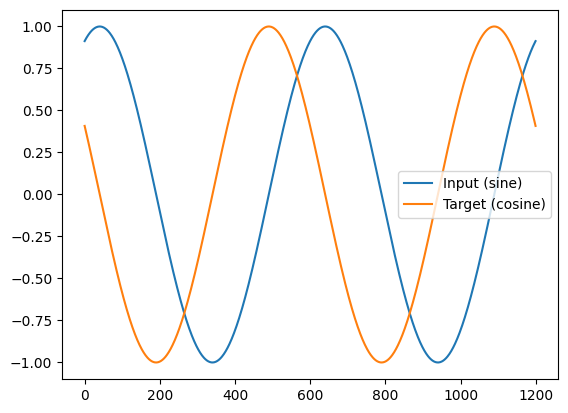

In [4]:
def generate_data(num_samples=1000, sequence_length=100):
    X = np.zeros((num_samples, sequence_length, 1))
    Y = np.zeros((num_samples, sequence_length, 1))
    
    for i in range(num_samples):
        rand_offset = np.random.randint(0, sequence_length)
        X[i, :, 0] = np.sin(np.linspace(0, 4 * np.pi, sequence_length) + rand_offset)
        Y[i, :, 0] = np.cos(np.linspace(0, 4 * np.pi, sequence_length) + rand_offset)
        
    return X, Y

input_shape = (1200, 1)

X, Y = generate_data(1000, input_shape[0])

# Let's visualize the first sample for sanity check
plt.plot(X[0], label='Input (sine)')
plt.plot(Y[0], label='Target (cosine)')
plt.legend()
plt.show()


In [6]:
input_shape = (1200, 1)
model = SelfAttentionuNet_1D(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 2000, 16)     64          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 2000, 16)    64          ['conv1d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 2000, 16)     0           ['batch_normalization_18[0]

In [6]:
# Train the model
model.fit(X, Y, epochs=10, batch_size=5)

Epoch 1/10
112/200 [===============>..............] - ETA: 5s - loss: 0.3425 - accuracy: 8.7798e-05

KeyboardInterrupt: 